In [1]:
%run PBM.ipynb
import matplotlib.pyplot as plt

# Aggregation test
Analytical solution with constant coalescence kernel by Gelbard and Seinfield (1978) with dimensionless length and number is
\begin{equation}
\tilde{N}_i=\frac{2}{\tau+2}\left[\exp\left(-\frac{2\tilde{L}_i^3}{\tau+2}\right)-\exp\left(-\frac{4\tilde{L}_i^3}{\tau+2}\right)\right]
\end{equation}


In [2]:
def anal_const_kernel(t,L):
    L = L.reshape((len(L),1))
    N = 2/(t+2)*(np.exp(-2*np.power(L,3)/(t+2))-np.exp(-4*np.power(L,3)/(t+2)))
    return N

def anal_const_kernel_array(tau,L):
    N = anal_const_kernel(tau[0],L)
    for i in range(1,len(tau)):
        N = np.append(N,anal_const_kernel(tau[i],L),axis=1)
    return N

In [3]:
from scipy.integrate import solve_ivp,Radau

tau = np.array([0,0.25,1,2])
# initial condition
n = 19
L = np.zeros(n)
L[0] = 1.5e-1
for i in range(n-1):
    L[i+1] = L[i]*2**(1/3)
N0 = anal_const_kernel(tau[0],L)
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0=np.append(N0,[m00,m10,m20,m30])

beta = np.ones((n,n))

def dydx(t,y):
    return aggregation_moment(y,beta)
sol = solve_ivp(dydx,[tau[0],tau[-1]],Y0,method='Radau',t_eval=tau) 

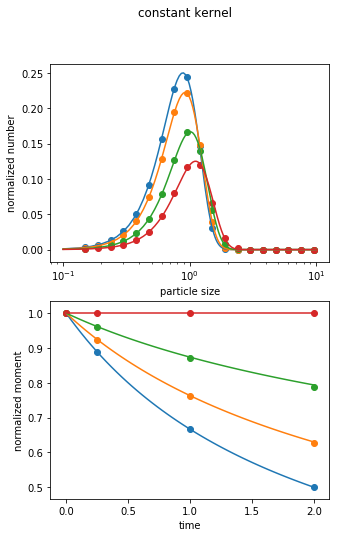

In [4]:
tau = np.array([0,0.25,1,2])
xx = np.linspace(0.1,10,300)
anal_sol = anal_const_kernel_array(tau,xx)

n = sol.y[0:-4,:]
m = sol.y[-4:,:]

plt.figure(figsize=(5,8))
plt.subplot(211)
plt.suptitle('constant kernel')
plt.xscale('log')
plt.xlabel('particle size')
plt.ylabel('normalized number')

for i in range(len(tau)):
    plt.plot(xx,anal_sol[:,i])
    plt.scatter(L,n[:,i])

m_norm = np.empty(np.shape(m))
for i in range(4):
    m_norm[i,:] = m[i,:]/m[i,0]
tau_anal = np.linspace(tau[0],tau[-1],50)
m_anal = np.empty([4,len(tau_anal)])
for i in range(4):
    m_anal[i,:] = np.power(2/(tau_anal+2),1-i/3)
plt.subplot(212)
plt.xlabel('time')
plt.ylabel('normalized moment')
for i in range(4):
    plt.plot(tau_anal,m_anal[i,:])
    plt.scatter(tau,m_norm[i,:])


# Breakage test
Testing the model with the selection rate of
\begin{equation*}
S(l)=l^3
\end{equation*}
and binary breakage funtion that gives uniform probability of all fragment sizes on a volume scale $b(\epsilon,v)=1/v$
\begin{equation*}
b(x,l)=\frac{6x^2}{l^3}
\end{equation*}
These gives
\begin{equation}
\begin{aligned}
b_{j,i}=&\left(\frac{\overline{l}_i}{\overline{l}_j}\right)^3\frac{\int_{l_i}^{l_{i+1}}\int_{l_j}^{l_{j+1}}x^3l^36x^2/l^3dxdl}{\int_{l_i}^{l_{i+1}}l^3l^3dl}\\
       =&\left(\frac{\overline{l}_i}{\overline{l}_j}\right)^3\frac{(l_{i+1}-l_{i})(l_{j+1}^6-l_j^6)}{\frac{1}{7}(l_{i+1}^7-l_i^7)}\\
       =&r^{3(j-i)}\frac{7(r-1)(r^6-1)}{r^7-1}=1.35118\times2^{j-i}\\
b_{i,i}=&\frac{\int_{l_i}^{l_{i+1}}\int_{l_j}^lx^3l^36x^2/l^3dxdl}{\int_{l_i}^{l_{i+1}}l^3l^3dl}=\frac{\frac{1}{7}(l_{i+1}^7-l_i^7)-l_i^6(l_{i+1}-l_i)}{\frac{1}{7}(l_{i+1}^7-l_i^7)}\\
  =&1-\frac{7(r-1)}{r^7-1}=0.549607
\end{aligned}
\end{equation}


In [5]:
def uniform_breakage(n):
    b = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            b[i][j]=1.35118*2**(i-j)
        b[i][i]=0.549607
    return b

Average number of fragments produced is
\begin{equation*}
N_b(l)=\int_0^l6x^2/l^3dx=2
\end{equation*}
Therefore
\begin{equation}
\begin{aligned}
S_i=&\frac{\frac{1}{l_{i+1}-l_i}\int_{l_i}^{l_{i+1}}l^3dl}{\sum_{j=1}^ib_{j,i}-1}\\
   =&\frac{\frac{l_{i+1}^4-l_i^4}{4(l_{i+1}-l_i)}}{\sum_{j=1}^{i-1}1.35118\times2^{j-i}+0.549607-1}\\
   =&\frac{\frac{l_i^3(r^4-1)}{4(r-1)}}{1.35118\times(1-2^{1-i})-0.450393}\\
   =&\frac{1.46183}{0.90079-1.35118\times2^{1-i}}l_i^3\qquad(i\geq2)\\
S_1=&2.65978l_1^3
\end{aligned}
\end{equation}

In [6]:
def selection_uniform(n,L):
    S = np.zeros(n)
    for i in range(1,n):
        # i is replaced with i+1 because of Python index
        S[i] = 1.46183/(0.90079-1.35118*2**(1-(i+1)))*L[i]**3
    S[0] = 2.65978*L[0]**3
    return S

Analytic solution of number density for unform breakage is
\begin{equation}
n(t,l)=3l^2(1+t)^2e^{-l^3(1+t)}
\end{equation}
Intergration of number density results in number of fragments
\begin{equation}
\begin{aligned}
N_i&=\int_{l_i}^{l_{i+1}}3l^2(1+t)^2e^{-l^3(1+t)}\\
   &=\left[-(1+t)e^{-l^3(1+t)}\right]_{l_i}^{l_{i+1}}\\
   &=(1+t)\left[e^{-l_i^3(1+t)}-e^{-2l_i^3(1+t)}\right]
\end{aligned}
\end{equation}

In [7]:
def anal_uni_break(t,L):
    L = L.reshape(len(L),1)
    N = (1+t)*(np.exp(-np.power(L,3)*(1+t))-np.exp(-2*np.power(L,3)*(1+t)))
    return N

def anal_uni_break_array(T,L):
    N = anal_uni_break(T[0],L)
    for i in range(1,len(T)):
        N = np.append(N,anal_uni_break(T[i],L),axis=1)
    return N

In [8]:
T = np.array([0,0.9,3.5,13.4,100])
n = 21
L = np.empty(n)
L[0] = 0.02
for i in range(n-1):
    L[i+1] = L[i]*2**(1/3)
N0 = anal_uni_break(T[0],L)
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0=np.append(N0,[m00,m10,m20,m30])

b = uniform_breakage(n)
S = selection_uniform(n,L)

def dydx(t,y):
    return breakage(y,b,S)

sol2 = solve_ivp(dydx,[T[0],T[-1]],Y0,method='Radau',t_eval=T)

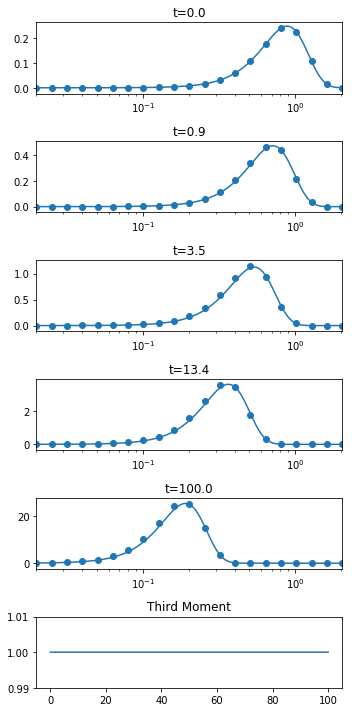

In [9]:
xx = np.linspace(L[0],L[-1],300)
anal_sol = anal_uni_break_array(T,xx)

N = sol2.y[0:-4,:]
M = sol2.y[-4:,:]

rows = len(T)
plt.close('all')
fig, axes = plt.subplots(rows+1,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(xx,anal_sol[:,i])
    axes[i].scatter(L,N[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))
M_norm = np.empty(np.shape(M))
for i in range(4):
    M_norm[i,:] = M[i,:]/M[i,0]
axes[rows].plot(T,M_norm[-1,:])
axes[rows].title.set_text('Third Moment')
axes[rows].set_ylim([0.99,1.01])
fig.tight_layout()

In [10]:
def b(x,y):
    return 6*x**2/y**3
def S(x):
    return x**3

# initial condition
T = np.array([0,0.9,3.5,13.4,100])
n = 21
L = np.empty(n)
L[0] = 0.02
for i in range(n-1):
    L[i+1] = L[i]*2**(1/3)
N0 = anal_uni_break(T[0],L)
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0=np.append(N0,[m00,m10,m20,m30])

break_mat = breakage_mat(n,b,S,L)
SR = selection_rate(n,S,L,b,break_mat)

In [11]:
def dydx(t,y):
    return breakage(y,break_mat,SR)

sol3 = solve_ivp(dydx,[T[0],T[-1]],Y0,method='Radau',t_eval=T)

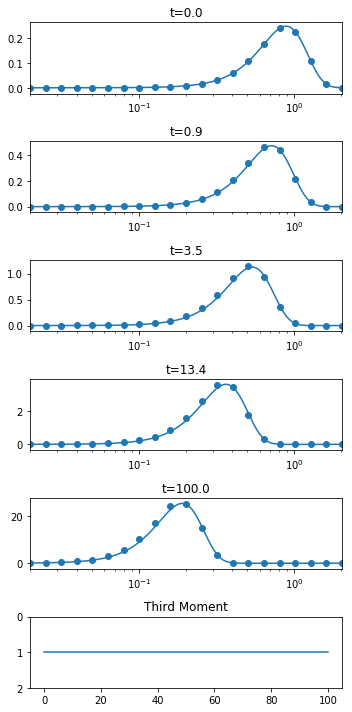

In [12]:
xx = np.linspace(L[0],L[-1],300)
anal_sol = anal_uni_break_array(T,xx)

N = sol3.y[0:-4,:]
M = sol3.y[-4:,:]

rows = len(T)
plt.close('all')
fig, axes = plt.subplots(rows+1,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(xx,anal_sol[:,i])
    axes[i].scatter(L,N[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))
M_norm = np.empty(np.shape(M))
for i in range(4):
    M_norm[i,:] = M[i,:]/M[i,0]
axes[rows].plot(T,M_norm[-1,:])
axes[rows].title.set_text('Third Moment')
axes[rows].set_ylim([2,0])
fig.tight_layout()

### Test of log normal distribution

In [13]:
n = 21
L = np.empty(n)
L[0] = 0.02
for i in range(n-1):
    L[i+1] = L[i]*2**(1/3)
lgv = 0.2
sg = 1.3
p = 3
def selection(x):
    return x**p
def break_func(x,l):
    return lognorm_b(x,l,lgv,sg)
b_logn = breakage_mat(n,break_func,selection,L)

In [14]:
T = np.array([0,0.002,0.004,0.006,0.008,0.01])*1e3
N0 = anal_uni_break(T[0],L)
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0 = np.append(N0,[m00,m10,m20,m30])

def dydx(t,y):
    return breakage(y,b_logn,SR)

sol4 = solve_ivp(dydx,[T[0],T[-1]],Y0,method='Radau',t_eval=T)

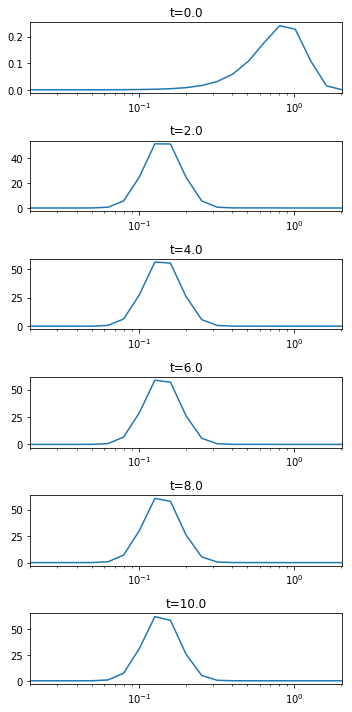

In [15]:
N = sol4.y[0:-4,:]
M = sol4.y[-4:,:]

rows = len(T)

plt.close('all')
fig, axes = plt.subplots(rows,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,N[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))

fig.tight_layout()

In [17]:
V= np.empty(np.shape(N))
for i in range(6):
    V[:,i] = np.multiply(N[:,i],L**3)

In [18]:
for i in range(6):
    print(np.sum(V[:,i]))

0.7213485414110389
0.7213485414110803
0.721348541411122
0.721348541411152
0.7213485414111906
0.72134854141121


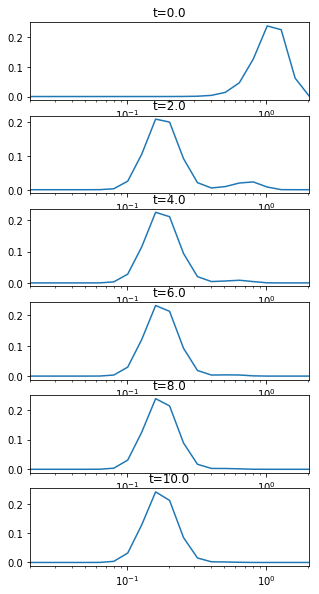

In [20]:
fig, axes = plt.subplots(rows,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,V[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))